In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/handwriting-recognition/mnist_test.csv
/kaggle/input/handwriting-recognition/t10k-images.idx3-ubyte


In [2]:
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import cv2#refers to the OpenCV library in Python

In [3]:
def load_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
    return images

In [4]:
def load_mnist_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

In [5]:
image_file_path = '/kaggle/input/handwriting-recognition/t10k-images.idx3-ubyte'
label_file_path = '/kaggle/input/handwriting-recognition/mnist_test.csv'

In [6]:
images = load_mnist_images(image_file_path)
labels = load_mnist_labels(label_file_path)

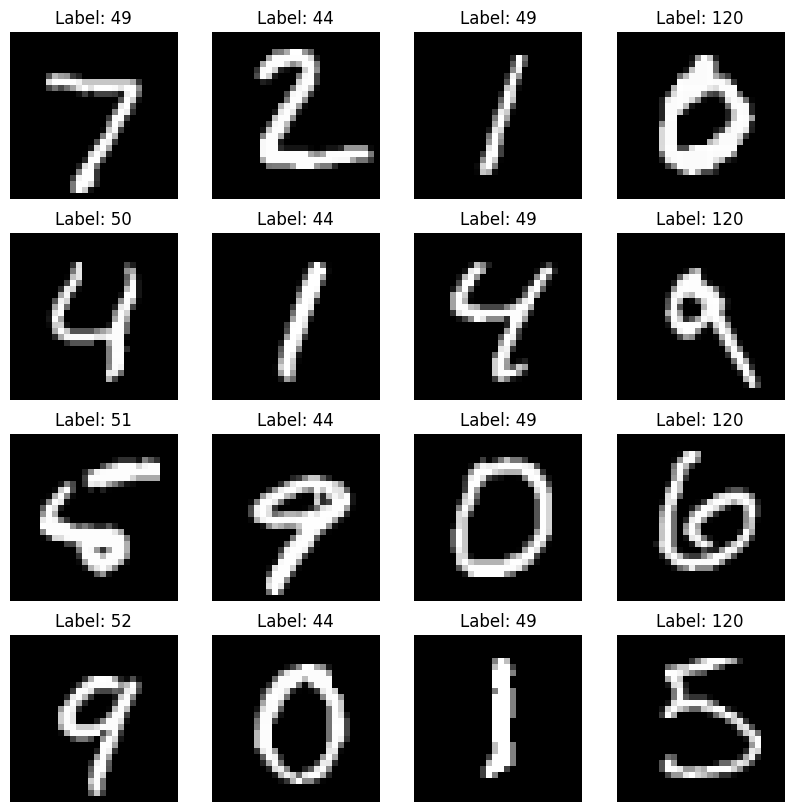

In [7]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.show()

In [8]:
file_path = '/kaggle/input/handwriting-recognition/mnist_test.csv'
df = pd.read_csv(file_path)

In [9]:
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df.tail()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9999,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 59.9 MB


In [12]:
df.describe()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
count,10000.000000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.000000,10000.000000,10000.000000,10000.0000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,4.443400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.179300,0.163600,0.052600,0.0006,0.0,0.0,0.0,0.0,0.0,0.0
std,2.895865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.674149,5.736072,2.420004,0.0600,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,253.000000,156.000000,6.0000,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df.isnull().sum()

label    0
1x1      0
1x2      0
1x3      0
1x4      0
        ..
28x24    0
28x25    0
28x26    0
28x27    0
28x28    0
Length: 785, dtype: int64

In [14]:
df.shape

(10000, 785)

In [15]:
df.columns

Index(['label', '1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9',
       ...
       '28x19', '28x20', '28x21', '28x22', '28x23', '28x24', '28x25', '28x26',
       '28x27', '28x28'],
      dtype='object', length=785)

In [16]:
df['label'].value_counts()

label
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: count, dtype: int64

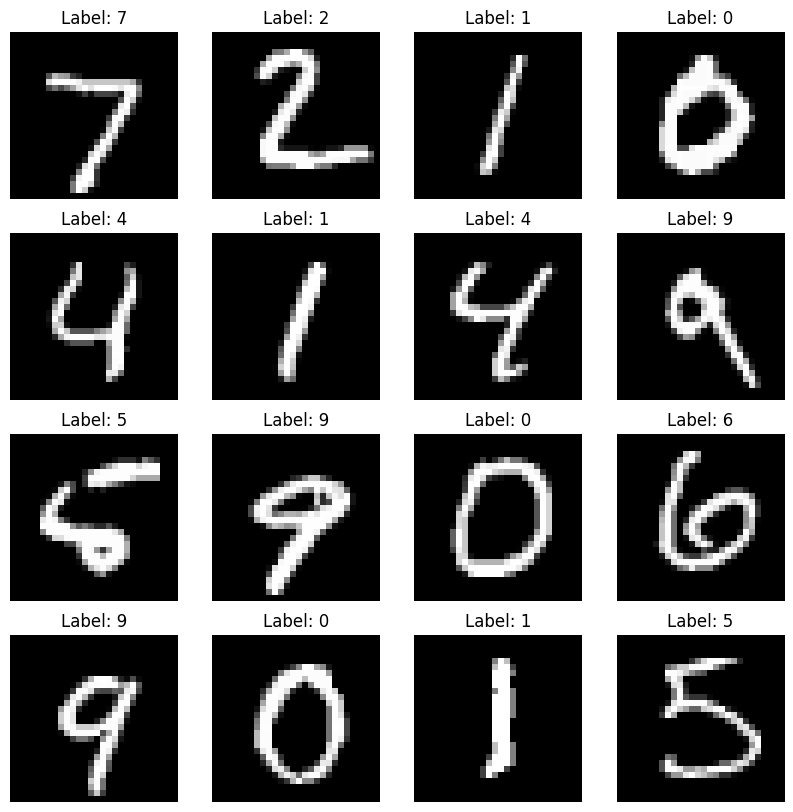

In [17]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(df.iloc[i, 1:].values.reshape(28, 28), cmap='gray')
    plt.title(f'Label: {df.iloc[i, 0]}')
    plt.axis('off')
plt.show()

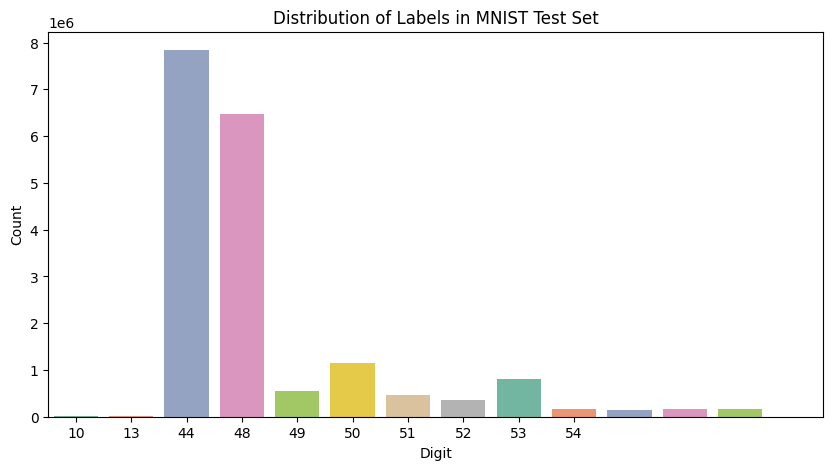

In [18]:
plt.figure(figsize=(10, 5))
sns.countplot(x=labels, palette='Set2')
plt.title('Distribution of Labels in MNIST Test Set')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.xticks(range(10))
plt.show()

In [19]:
images1 = images.reshape(images.shape[0], -1)[:1000]

In [20]:
subset = df[df['label'] < 5]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


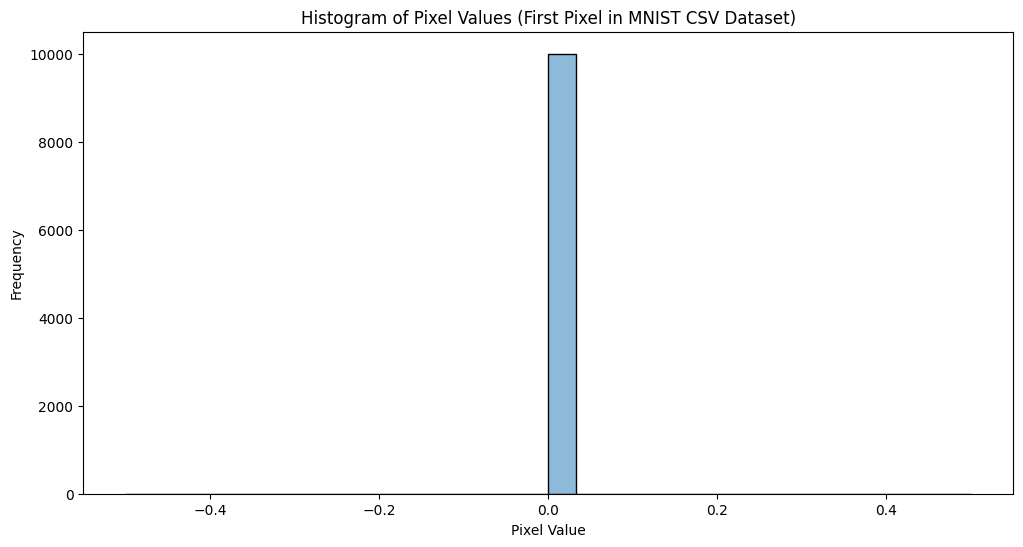

In [21]:
plt.figure(figsize=(12, 6))
sns.histplot(df.iloc[:, 1], bins=30, kde=True)  # First pixel
plt.title('Histogram of Pixel Values (First Pixel in MNIST CSV Dataset)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [22]:
print(f"Labels shape: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")

Labels shape: (18303642,)
Unique labels: [ 10  13  44  48  49  50  51  52  53  54  55  56  57 120]


In [23]:
digit_counts = np.bincount(labels, minlength=10)
print(f"Digit counts: {digit_counts}")

Digit counts: [      0       0       0       0       0       0       0       0       0
       0   10001       0       0   10001       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0 7840783
       0       0       0 6481412  546928 1158118  474844  353867  803224
  157332  148724  159798  157827       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0     783]


In [24]:
digit = df[df['label'] == 0].iloc[:, 1:]

In [25]:
average_intensities = digit.mean(axis=1)
image_indices = range(len(average_intensities))

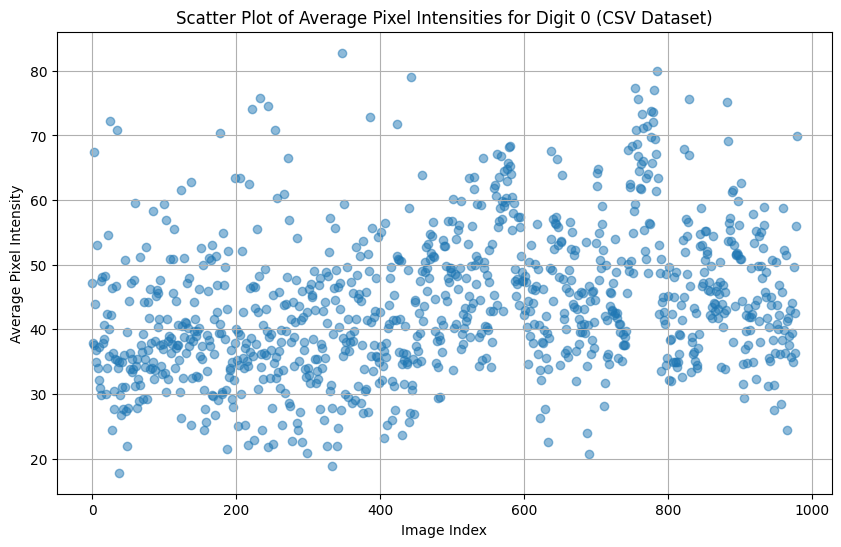

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(image_indices, average_intensities, alpha=0.5)
plt.title('Scatter Plot of Average Pixel Intensities for Digit 0 (CSV Dataset)')
plt.xlabel('Image Index')
plt.ylabel('Average Pixel Intensity')
plt.grid(True)
plt.show()

In [27]:
X = df.iloc[:, 1:].values
y = df['label'].values    

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train.shape

(8000, 784)

In [30]:
X_test.shape

(2000, 784)

In [31]:
y_train.shape

(8000,)

In [32]:
y_test.shape

(2000,)

In [33]:
#Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

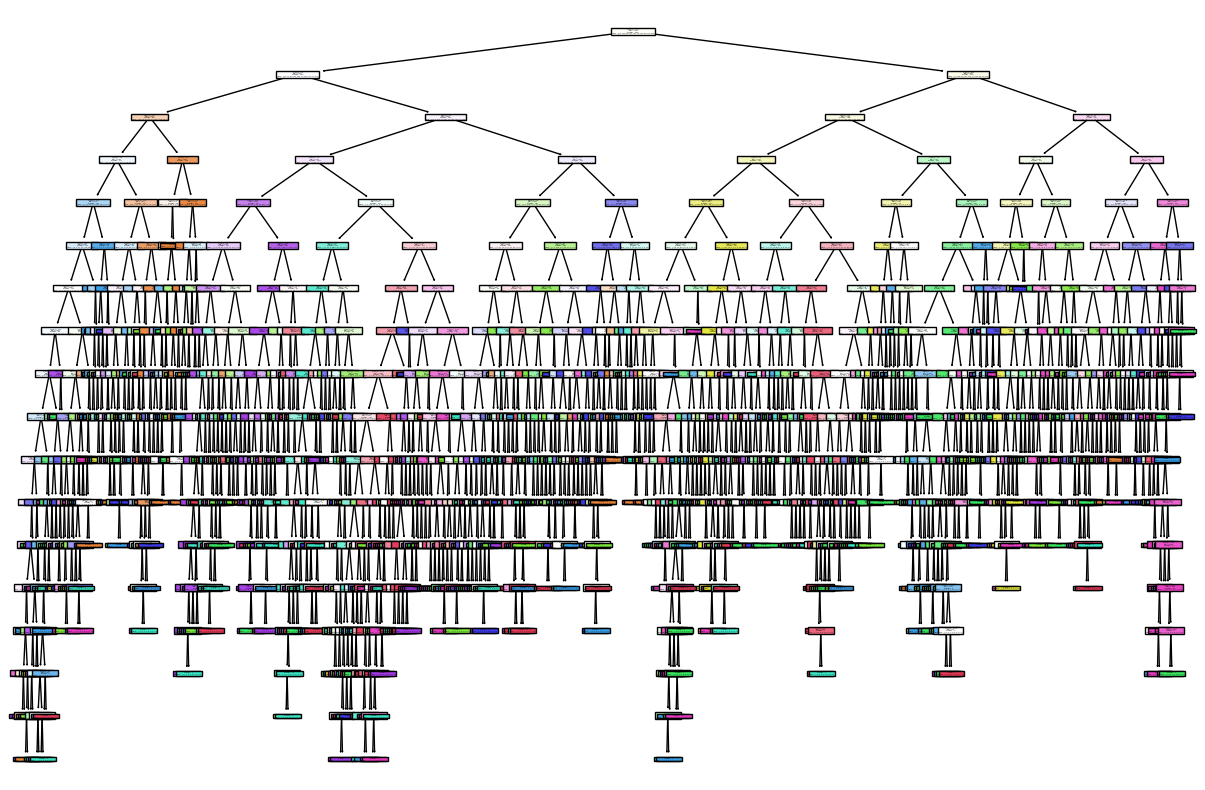

In [35]:
from sklearn import tree
plt.figure(figsize=(15, 10))
tree.plot_tree(rf.estimators_[0], filled=True)
plt.show()

In [36]:
y_pred = rf.predict(X_test)

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.952


In [38]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       203
           1       0.99      0.98      0.98       216
           2       0.94      0.95      0.94       213
           3       0.96      0.95      0.95       208
           4       0.93      0.93      0.93       215
           5       0.98      0.94      0.96       174
           6       0.93      0.96      0.95       200
           7       0.96      0.95      0.95       187
           8       0.96      0.93      0.94       186
           9       0.93      0.94      0.94       198

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



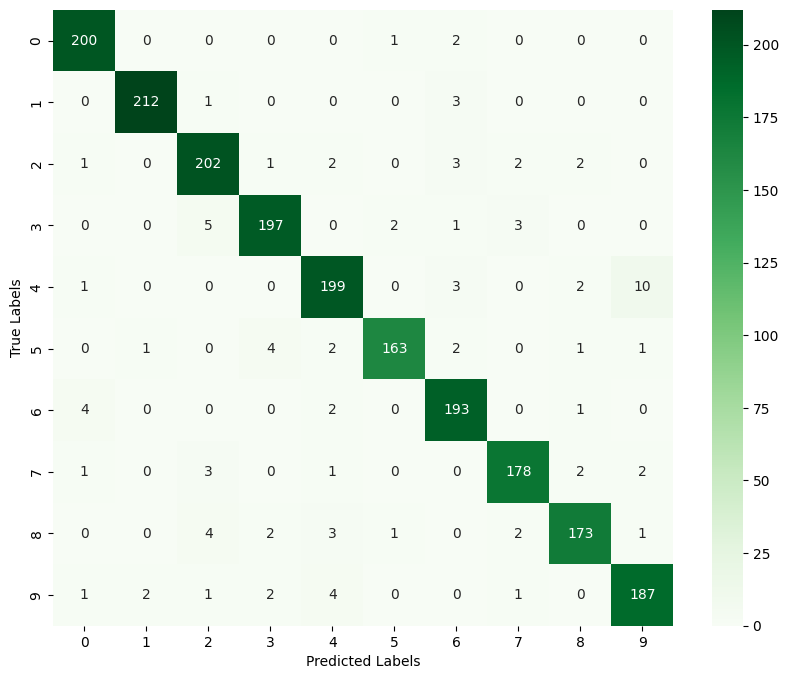

In [39]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [40]:
param_grid = {
      'n_estimators': [10, 50],    
    'max_depth': [5, 10],         
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5]     
}

In [41]:
grid_search = GridSearchCV( RandomForestClassifier(random_state=42), param_grid,cv=3,scoring='accuracy',verbose=2,n_jobs=-1   )
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}


In [42]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning:", accuracy)

Accuracy after tuning: 0.952


In [43]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       203
           1       0.99      0.98      0.98       216
           2       0.94      0.95      0.94       213
           3       0.96      0.95      0.95       208
           4       0.93      0.93      0.93       215
           5       0.98      0.94      0.96       174
           6       0.93      0.96      0.95       200
           7       0.96      0.95      0.95       187
           8       0.96      0.93      0.94       186
           9       0.93      0.94      0.94       198

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



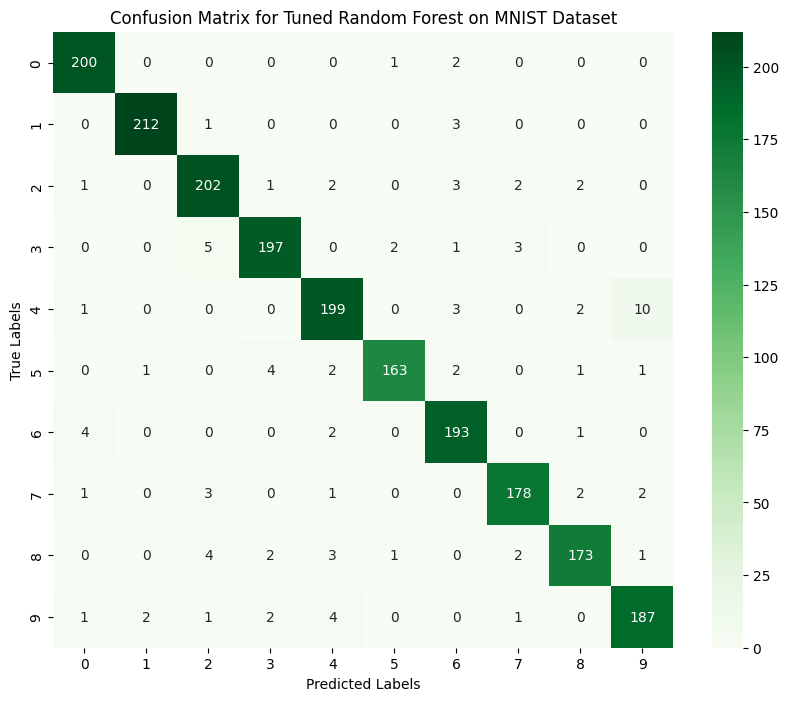

In [44]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Tuned Random Forest on MNIST Dataset")
plt.show()

In [45]:
#Support Vector Machine

In [46]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [47]:
y_pred = svm_model.predict(X_test)

In [48]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9635


In [49]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       203
           1       0.99      0.99      0.99       216
           2       0.96      0.97      0.96       213
           3       0.96      0.97      0.96       208
           4       0.94      0.95      0.95       215
           5       0.97      0.96      0.97       174
           6       0.95      0.95      0.95       200
           7       0.95      0.97      0.96       187
           8       0.99      0.96      0.97       186
           9       0.96      0.93      0.94       198

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



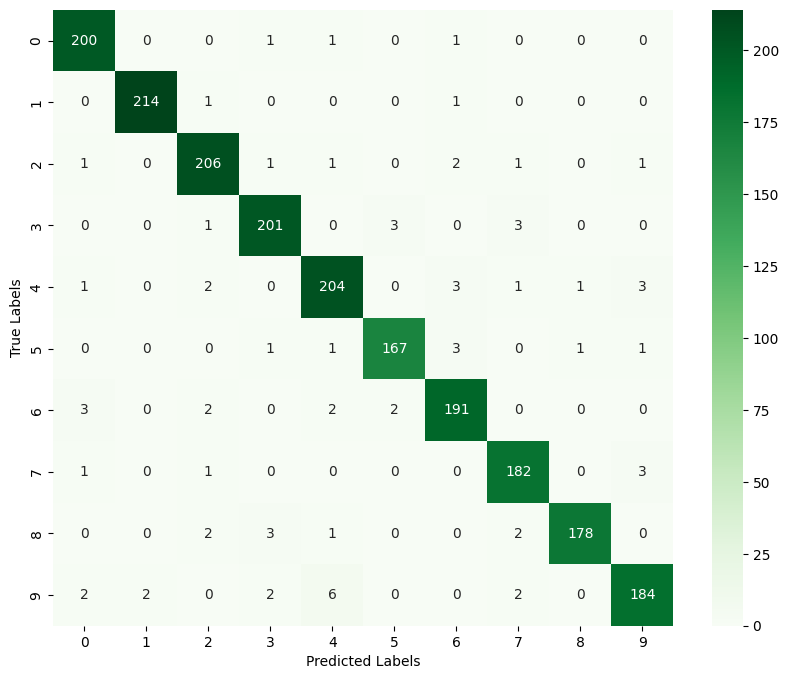

In [50]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [51]:
param_grid = {
    'C': [0.1, 1, 10],              
    'kernel': ['linear', 'rbf'],    
    'gamma': ['scale', 'auto']       
}

In [52]:
grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [53]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning:", accuracy)

Accuracy after tuning: 0.9635


In [54]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       203
           1       0.99      0.99      0.99       216
           2       0.96      0.97      0.96       213
           3       0.96      0.97      0.96       208
           4       0.94      0.95      0.95       215
           5       0.97      0.96      0.97       174
           6       0.95      0.95      0.95       200
           7       0.95      0.97      0.96       187
           8       0.99      0.96      0.97       186
           9       0.96      0.93      0.94       198

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



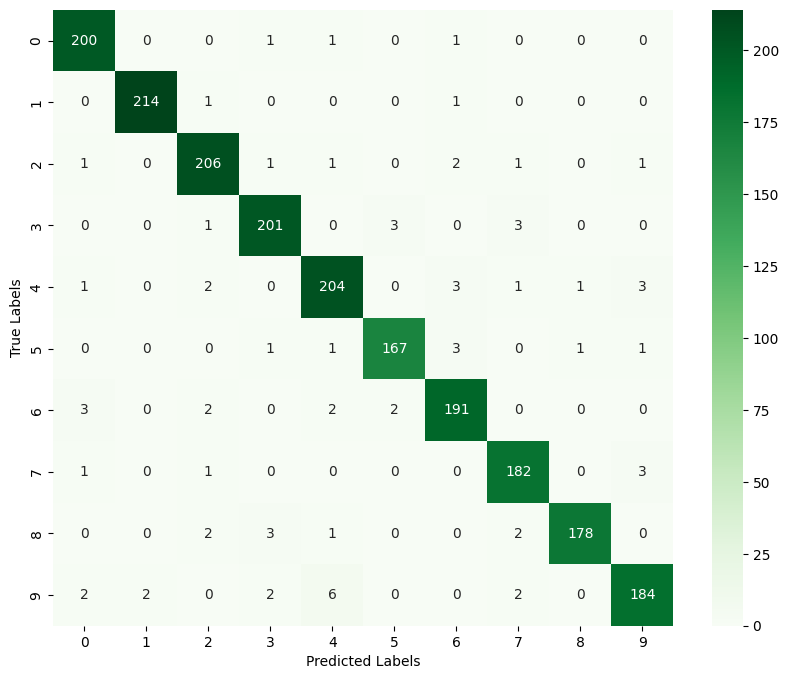

In [55]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [56]:
#Convolutional Neural Network (CNN)

In [57]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [58]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [59]:
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (60000, 28, 28, 1)
Testing data shape: (10000, 28, 28, 1)


In [60]:

X_train, X_test = X_train / 255.0, X_test / 255.0

In [61]:
model = models.Sequential()

In [62]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
#Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.8984 - loss: 0.3318 - val_accuracy: 0.9882 - val_loss: 0.0370
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.9850 - loss: 0.0477 - val_accuracy: 0.9892 - val_loss: 0.0347
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9899 - loss: 0.0322 - val_accuracy: 0.9889 - val_loss: 0.0356
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9922 - loss: 0.0235 - val_accuracy: 0.9881 - val_loss: 0.0392
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9946 - loss: 0.0177 - val_accuracy: 0.9908 - val_loss: 0.0287
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.9959 - loss: 0.0123 - val_accuracy: 0.9894 - val_loss: 0.0401
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9955 - loss: 0.0135 - val_accuracy: 0.9912 - val_loss: 0.0380
Epoch 8/10
 539/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9973 -

In [65]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

313/313 - 2s - 5ms/step - accuracy: 0.9913 - loss: 0.0371
Test accuracy: 99.13%


In [66]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probability output to class labels

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [67]:
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



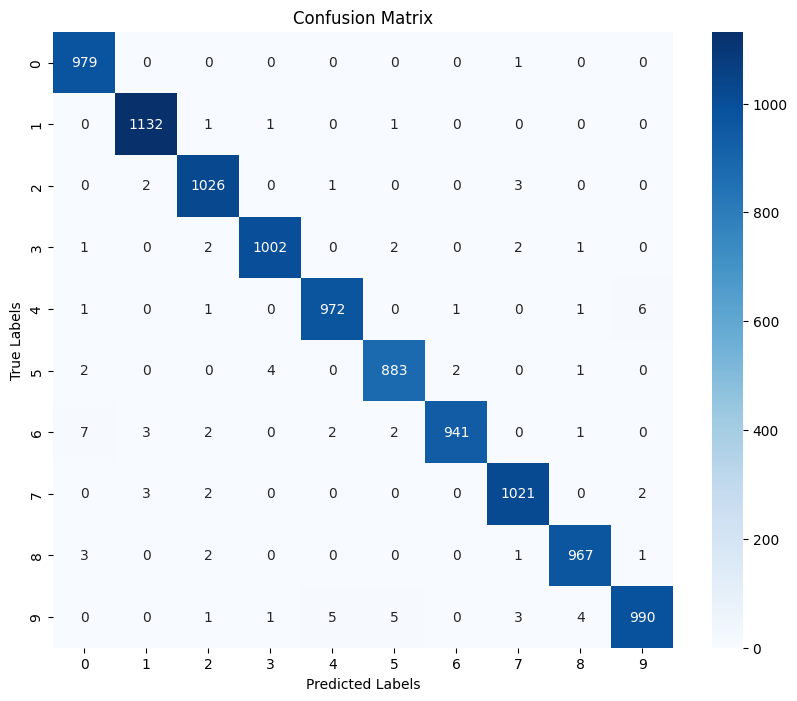

In [68]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

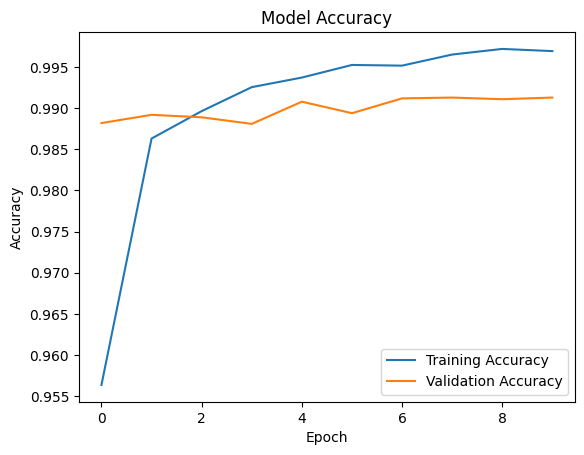

In [69]:
#Plot training history (Accuracy)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

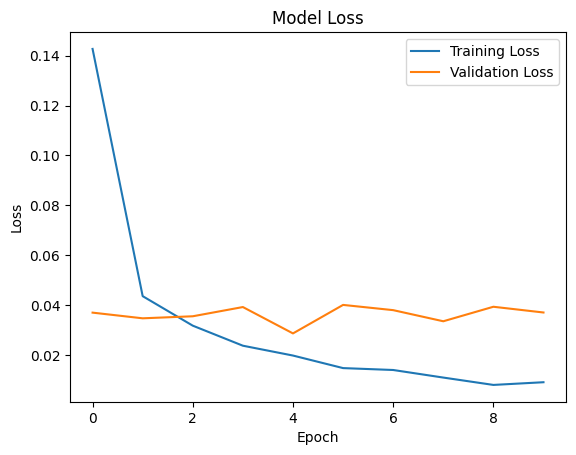

In [70]:
#Plot training history (Loss)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()